In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

In [97]:
U = 50000
# veličina ciklotrona
r0 = 0.07

#
rolling_friction_coef = 0.02
g = 9.81
##Vanjski parametri
epsilon =  1.0006*8.854187*10**-12
# 'Naboj' na dipolima
q0 = np.float32(epsilon * (U*20*10**-4) / (2*r0))
print(q0)


# veličina loptice


#masa ping pong loptice (internet)
m_loptica = 0.027
r_loptice = 0.015
delta = r_loptice
#račun naboja na loptici
C_loptica = np.float32(4 * np.pi * epsilon * r_loptice)
global q_loptica,bottom
q_loptica = U * C_loptica
bottom = False

#sila trenja:
Ftr = -rolling_friction_coef * m_loptica * g

print(q_loptica)

6.328214e-09
8.349882e-08


In [98]:


def arctan_special(x0,y0):
    theta_one = np.zeros(x0.size)
    for i in range(x0.size):
        ph = np.arctan(y0[i] / x0[i])
        if (x0[i] < 0 and y0[i] > 0):
            ph += np.pi
        elif (x0[i] < 0 and y0[i] < 0):
            ph -= np.pi
        theta_one[i]= ph
    return theta_one

r1 =  np.linspace(0.001,r0,30)
theta0 = np.linspace(0, np.pi * 2 +np.pi/12,30)
r,theta = np.meshgrid(r1,theta0)
r = r.flatten()
theta = theta.flatten()
x = r * np.cos(theta)
y = r * np.sin(theta)

#fig = plt.figure(figsize=(8, 6))
#ax = fig.add_subplot(111)
#ax.scatter(x,y,color='b',marker=".")

In [99]:
const_1 = 1.0 / (4*np.pi*1.0006*8.854187*10**-12)
def E(r,theta):
    s1 = (np.cos(theta)**2 + (np.sin(theta) -r0/r- delta/r)**2)
    r1 = r * np.sqrt(s1)
    s2 = (np.cos(theta)**2 + (np.sin(theta) +r0/r+ delta/r)**2)
    r2 = r * np.sqrt(s2)

    E_x = (const_1 * q0 * r * np.cos(theta))*(1/ r1**3 - 1 / r2**3)
    E_y = (const_1 * q0 * (r * np.sin(theta) -r0 - delta))/ r1**3 - (const_1 * q0 * (r * np.sin(theta) +r0 + delta)) / r2**3
    return E_x,E_y

def get_radial_tangential_E(Ex,Ey,theta):
    E_r = Ex * np.cos(theta) + Ey*np.sin(theta)
    E_t = -Ex * np.sin(theta) - Ey * np.cos(theta)
    return E_r,E_t

def step_fun(x, a = 0.01):
    return (1 + x/a) * (-np.tanh(x/a) - 1)

#ovdje ide zid, sam zamijeni ovo ne radi najbolje
def step_force(r,F_x=0,F_y=0,v_x=0,v_y=0,theta=0 ):
    v_tan = np.sqrt((v_x*np.sin(theta))**2 + (v_y*np.cos(theta))**2)
    Fcf = m_loptica * (v_tan)**2 / r
    F_rad = F_x * np.cos(theta) + F_y * np.sin(theta)
    resistance = (Fcf+F_rad) * step_fun(r-r0)
    return resistance * np.cos(theta), resistance* np.sin(theta)

def akceleracija(x,y,v_x,v_y):
    global bottom, q_loptica
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    field = E(r,theta)
    r_x, r_y = step_force(r,field[0]*q_loptica,field[1]*q_loptica,v_x,v_y,theta)
    a_x = (field[0] * q_loptica + (Ftr)*np.tanh(v_x/0.1) + r_x) / m_loptica
    a_y = (field[1] * q_loptica + (Ftr)*np.tanh(v_y/0.1) + r_y) / m_loptica
    if x < -delta/2 and -r0-delta < y < -r0+delta and not bottom:
        print("Damnnn",x,y)
        bottom = True
        q_loptica *= -1
    if x > delta/2 and r0-delta < y < r0 and bottom:
        print("Damnnn2",x,y)
        bottom = False
        q_loptica *= -1


    return a_x,a_y


def func(t,y):
    a = akceleracija(y[0],y[1],y[2],y[3])
    return [y[2],y[3],a[0],a[1]]

    

In [100]:
x0 = np.asarray([r0/1.5,r0/2])
x0_dt = [0,0]
T_max = 60.0
n_t =  1000
dt = T_max / n_t
t = np.arange(0.0,T_max, dt)
y0 = [x0[0],x0[1],x0_dt[0],x0_dt[1]] 
## fun - prima vrijeme t i y[0] = x i y[1] = dx/dt kao poc uvjeti (duljina y0)
solution = solve_ivp(func,[0.0, T_max],y0,method="LSODA",t_eval = t)

Damnnn -0.007626377746890747 -0.06894360462435814
Damnnn2 0.0076545260056309055 0.06866298606135958
Damnnn -0.008160247783027326 -0.06891103573919657
Damnnn2 0.008449180392746482 0.06890701587082253
Damnnn -0.007794383157293177 -0.06894241227971387
Damnnn2 0.007949275838865798 0.06892726422771016
Damnnn -0.007539164556872437 -0.06894909961802681


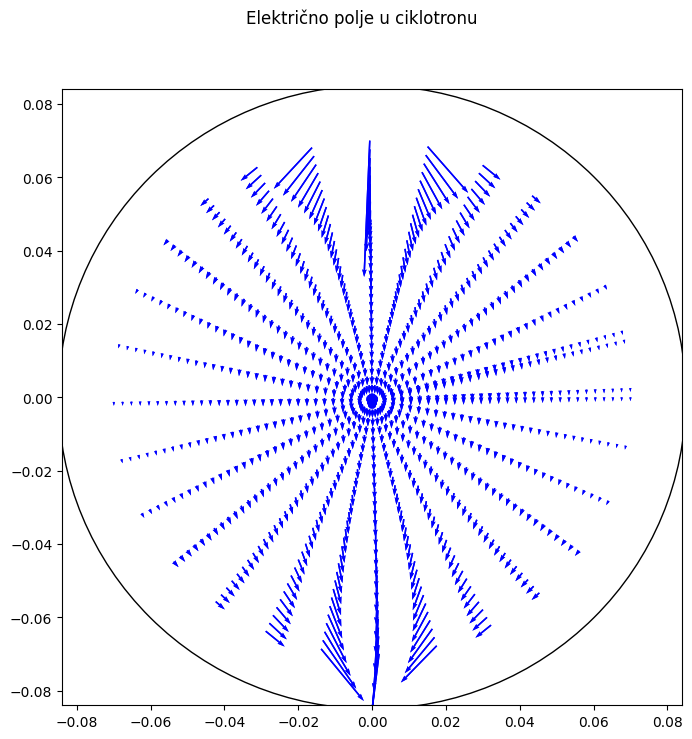

In [101]:
x = r * np.cos(theta)
y = r * np.sin(theta)
E_x,E_y= E(r,theta)
F_x = q_loptica * E_x
F_y = q_loptica * E_y
fig = plt.figure(figsize=(8, 8))
ax = fig.subplots(1,1)
fig.suptitle("Električno polje u ciklotronu")
ax.set_xlim(-r0* 1.2,r0 * 1.2)
ax.set_ylim(-r0*1.2,r0* 1.2)
circle = Circle((0, 0), r0+delta, fill=False)
ax.add_patch(circle)

ax.quiver(x,y,E_x,E_y,color='b')
ax.quiver(x,y,E_x,E_y,color='b')
ax.scatter(0,r0+delta,color="r",marker="+")
ax.scatter(0,-r0-delta,color="r",marker="_")



MovieWriter Pillow unavailable; using Pillow instead.


0.0028537084813841577 0.01149342917179771
-8.349882e-08


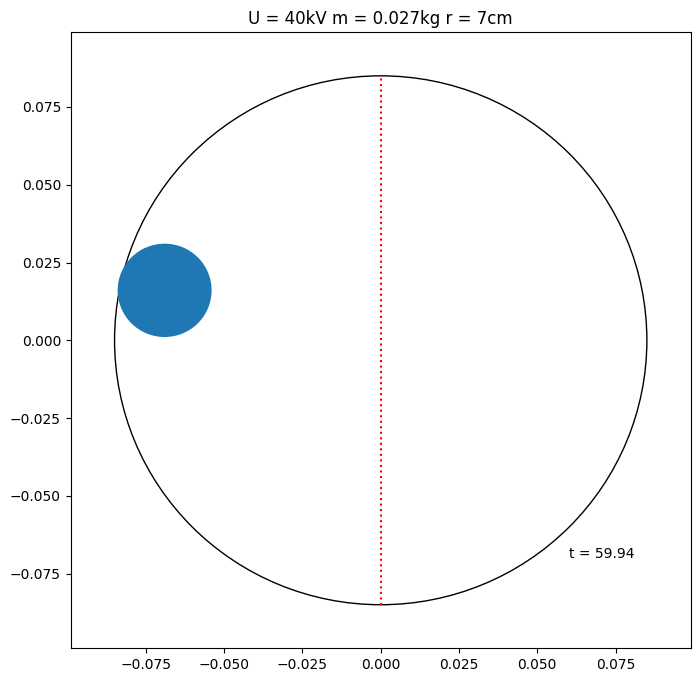

In [103]:
fig = plt.figure(figsize=(8, 8))
ax = fig.subplots(1,1)
E_r,E_t = get_radial_tangential_E(E_x,E_y,theta)
ax.set_xlim(-r0* 1.2-delta,r0 * 1.2+delta)
ax.set_ylim(-r0*1.2-delta,r0* 1.2+delta)
circle = Circle((0, 0), r0+delta, fill=False)
ax.add_patch(circle)
ax.plot([0,0],[-r0-delta,r0+delta], c = "r",  ls= ":")
ax.plot(solution.y[0,0],solution.y[1,0])
t = ax.text(0.06,-0.07, f"t={solution.t[0]}")
print(solution.y[2,-1],solution.y[3,-1])
print(q_loptica)
ax.set_title("U = 40kV m = 0.027kg r = 7cm")
#ax.plot(solution.y[0],solution.y[1])
c2 = Circle(x0, delta, fill=True)
c = ax.add_patch(c2)

def animate(i):
    b = t.set_text(f"t = {round(solution.t[i],2)}")
    c.set_center(xy =[solution.y[0,i],solution.y[1,i]])
    return [t,c2]


anim = animation.FuncAnimation(fig = fig, func = animate,frames = n_t, interval = T_max/n_t, blit = True)
anim.save("ANIMACIJA.gif", writer='Pillow',fps=round((n_t / T_max)))

In [254]:
plt.close()